# **EE 8225 IoT Analytics (Fall 2022) Group 2 Project: Malicious Traffic Classification using Transformer Neural Networks**

**Importing all necessary modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn import feature_selection
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

**TON_IoT Network Train_Test Dataset downloaded and stored on google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_orignial = pd.read_csv('/content/drive/MyDrive/EE 8225 IoT Analytics (Survey Project)/Train_Test_Network.csv')

## Dataset Pre-processing

The first five features are dropped since they tend to cause a bias towards normal classifcation.

In [4]:
dataset = dataset_orignial.drop(['ts','src_ip','src_port','dst_ip','dst_port','type'],axis = 1)
dataset = dataset.replace('-','null')
dataset =  dataset.sample(frac=1)

The string data type features have to be integer encoded. For calculation of mutual information, these features are treated as discrete. 

In [5]:
cols = []
discrete_index = []
for i in range(0,len(dataset.columns)):
    if (str(dataset.dtypes[i]) == 'object'):
        cols.append(dataset.columns[i])
        discrete_index.append(i)

Using sklearn's LabelEncoder to transform the string type features into integer encodeding.

In [6]:
dataset[cols] = dataset[cols].apply(preprocessing.LabelEncoder().fit_transform)

Features matrix and binary target labels are separately stored

In [7]:
feature_dataset = dataset.iloc[:,0:len(dataset.columns)-1]
label_dataset = dataset.iloc[:,len(dataset.columns)-1]

Mutual Information is calculated for each feature with respect to target values.

In [8]:
mutual_info = feature_selection.mutual_info_classif(feature_dataset,label_dataset, discrete_features = np.asarray(discrete_index))

The mutual information for each feature is plotted as a bar chart. 

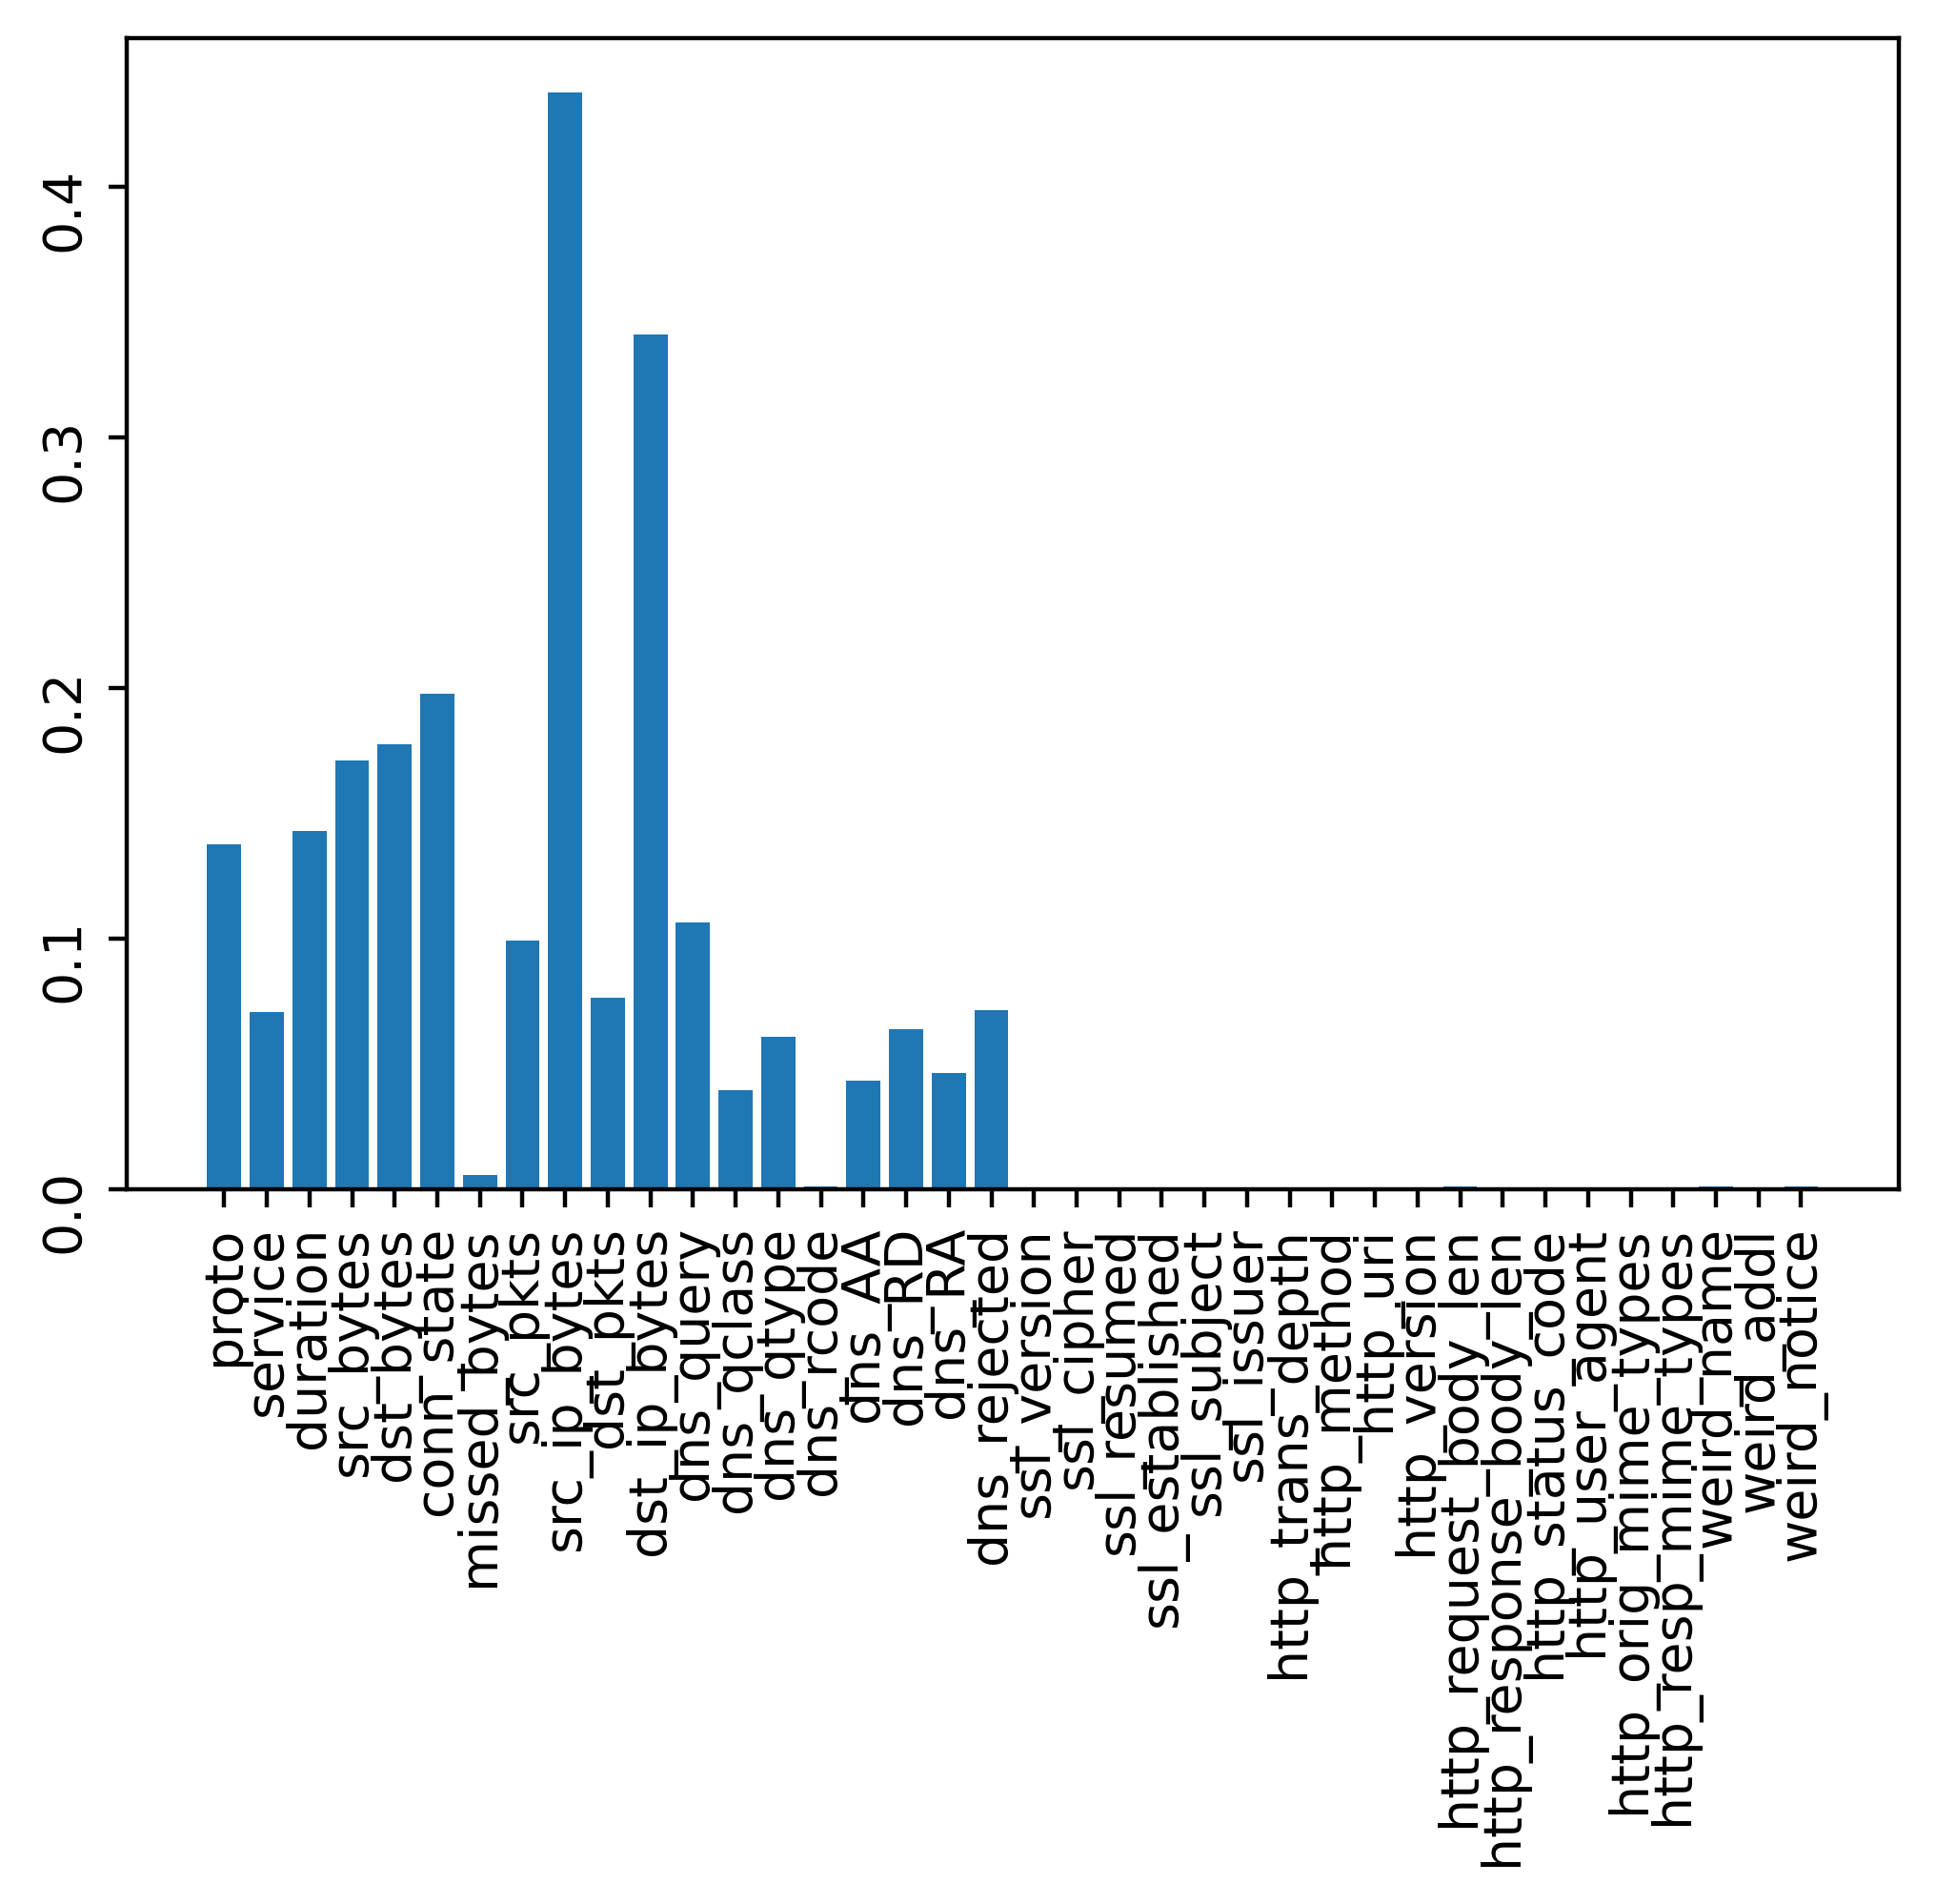

In [10]:
plt.bar(dataset.columns[0:len(dataset.columns)-1],mutual_info)
plt.tick_params(rotation=90)
plt.rcParams["figure.dpi"] = 400
plt.show()

For feature with mutaul information score less than 0.001 (based on experiments), said features are dropped.

In [11]:
drop_index = []
for i in range(0,len(feature_dataset.columns)):
    if (mutual_info[i] <= 0.001):
        drop_index.append(i)

feature_dataset.drop(feature_dataset.columns[drop_index], axis=1, inplace=True)

Training and Test datasets are created.

In [12]:
train_test_split_ratio = 0.5
Num_sequences = int(np.floor(len(feature_dataset)*train_test_split_ratio))

xtrain_set = feature_dataset.to_numpy()[0:Num_sequences]
xtest_set = feature_dataset.to_numpy()[Num_sequences:len(feature_dataset)]

ytrain_set = label_dataset.to_numpy()[0:Num_sequences]
ytest_set = label_dataset.to_numpy()[Num_sequences:len(feature_dataset)]

The feature training and test datasets are reshaped, as Tensorflow requires shape of 3D Tensors to be: (number of samples, sequence length, number of features).

In [13]:
xtrain_set = xtrain_set.reshape((xtrain_set.shape[0],xtrain_set.shape[1],1))
xtest_set = xtest_set.reshape((xtest_set.shape[0],xtest_set.shape[1],1))

##Transformer Neural Network Training and Testing

The transformer encoder is used only, the following code defines the basic transformer block to be used. Residual connections are also included.

In [14]:
def transformer_encoder(inputs, head_size, num_heads, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x,x)
    #x = layers.Dropout(dropout)(x)
    res = x + inputs

    return x + res

The build function is defined, with a dense feed forward neural network connected to the output of transformer encoder.

In [15]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        #x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1,activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

Hyperparametrs for the transformer neural network are defined and the model is compiled.

In [16]:
input_shape = xtrain_set.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    num_transformer_blocks=1,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["binary_accuracy",keras.metrics.Precision(),keras.metrics.Recall()],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 22, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 22, 1)       7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

The model is instantiated and trained.

In [17]:
transformer_history = model.fit(
    xtrain_set,
    ytrain_set,
    validation_split=0.2,
    epochs=10,
    batch_size = 64,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10
2882/2882 [==============================] - 24s 7ms/step - loss: 96.7205 - binary_accuracy: 0.6390 - precision: 0.4836 - recall: 0.4751 - val_loss: 8.6683 - val_binary_accuracy: 0.6991 - val_precision: 0.7833 - val_recall: 0.1857
Epoch 2/10
2882/2882 [==============================] - 19s 7ms/step - loss: 10.7402 - binary_accuracy: 0.7477 - precision: 0.6552 - recall: 0.5884 - val_loss: 81.4797 - val_binary_accuracy: 0.7400 - val_precision: 0.7261 - val_recall: 0.4047
Epoch 3/10
2882/2882 [==============================] - 18s 6ms/step - loss: 174.7081 - binary_accuracy: 0.7730 - precision: 0.6912 - recall: 0.6344 - val_loss: 4.9573 - val_binary_accuracy: 0.8675 - val_precision: 0.7833 - val_recall: 0.8555
Epoch 4/10
2882/2882 [==============================] - 18s 6ms/step - loss: 6.0584 - binary_accuracy: 0.7857 - precision: 0.7083 - recall: 0.6585 - val_loss: 4.4190 - val_binary_accuracy: 0.8675 - val_precision: 0.7578 - val_recall: 0.9094
Epoch 5/10
2882/2882 [=========

The model is evaluated on test dataset.

In [18]:
model.evaluate(xtest_set, ytest_set, verbose=1)

7204/7204 [==============================] - 27s 4ms/step - loss: 230.0262 - binary_accuracy: 0.8779 - precision: 0.7795 - recall: 0.9069


[230.02618408203125,
 0.8778945207595825,
 0.7795023322105408,
 0.9069490432739258]

## LSTM Training and Testing

A simple Long Short Term Memory (LSTM) Neural Network is defined for comparision with transformer neural network.

In [19]:
lstm_model = Sequential()
lstm_model.add(LSTM(100,input_shape = xtrain_set.shape[1:]))
lstm_model.add(Dense(128,activation="relu"))
lstm_model.add(Dense(1,activation="sigmoid"))

Hyperparametrs for the LSTM neural network are defined and the model is compiled.

In [20]:
lstm_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["binary_accuracy",keras.metrics.Precision(),keras.metrics.Recall()],
)
lstm_model.summary()

lstm_callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 128)               12928     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 53,857
Trainable params: 53,857
Non-trainable params: 0
_________________________________________________________________


LSTM Model is instantiated and trained.

In [21]:
lstm_history = lstm_model.fit(
    xtrain_set,
    ytrain_set,
    validation_split=0.2,
    epochs=10,
    batch_size = 64,
    callbacks = lstm_callbacks,
    shuffle = True,
)

Epoch 1/10
2882/2882 [==============================] - 26s 7ms/step - loss: 0.3393 - binary_accuracy: 0.8327 - precision_1: 0.7646 - recall_1: 0.7539 - val_loss: 0.2505 - val_binary_accuracy: 0.8851 - val_precision_1: 0.9031 - val_recall_1: 0.7499
Epoch 2/10
2882/2882 [==============================] - 21s 7ms/step - loss: 0.2075 - binary_accuracy: 0.9084 - precision_1: 0.8442 - recall_1: 0.9053 - val_loss: 0.1635 - val_binary_accuracy: 0.9252 - val_precision_1: 0.8545 - val_recall_1: 0.9460
Epoch 3/10
2882/2882 [==============================] - 21s 7ms/step - loss: 0.1580 - binary_accuracy: 0.9299 - precision_1: 0.8809 - recall_1: 0.9247 - val_loss: 0.1920 - val_binary_accuracy: 0.8898 - val_precision_1: 0.9182 - val_recall_1: 0.7498
Epoch 4/10
2882/2882 [==============================] - 21s 7ms/step - loss: 0.1352 - binary_accuracy: 0.9424 - precision_1: 0.9032 - recall_1: 0.9356 - val_loss: 0.1241 - val_binary_accuracy: 0.9488 - val_precision_1: 0.9480 - val_recall_1: 0.9021
Epoc

LSTM model is evaluated on test dataset.

In [22]:
lstm_model.evaluate(xtest_set, ytest_set, verbose=1)

7204/7204 [==============================] - 42s 6ms/step - loss: 0.0785 - binary_accuracy: 0.9742 - precision_1: 0.9485 - recall_1: 0.9792


[0.07851795852184296,
 0.9741586446762085,
 0.9485177397727966,
 0.9791591763496399]

## RNN Training and Testing

A simple Recurrent Neural Network (RNN) is defined for comparision with transformer neural network.

In [23]:
SimpleRNN_model = Sequential()
SimpleRNN_model.add(SimpleRNN(100,input_shape = xtrain_set.shape[1:]))
SimpleRNN_model.add(Dense(128,activation="relu"))
SimpleRNN_model.add(Dense(1,activation="sigmoid"))

Hyperparametrs for the RNN are defined and the model is compiled.

In [24]:
SimpleRNN_model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["binary_accuracy",keras.metrics.Precision(),keras.metrics.Recall()],
)
SimpleRNN_model.summary()

SimpleRNN_callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense_4 (Dense)             (None, 128)               12928     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,257
Trainable params: 23,257
Non-trainable params: 0
_________________________________________________________________


RNN Model is instantiated and trained.

In [25]:
SimpleRNN_history = SimpleRNN_model.fit(
    xtrain_set,
    ytrain_set,
    validation_split=0.2,
    epochs=10,
    batch_size = 64,
    callbacks = lstm_callbacks,
    shuffle = True,
)

Epoch 1/10
2882/2882 [==============================] - 48s 16ms/step - loss: 0.5690 - binary_accuracy: 0.6587 - precision_2: 0.7528 - recall_2: 0.0362 - val_loss: 0.5571 - val_binary_accuracy: 0.6647 - val_precision_2: 0.9548 - val_recall_2: 0.0369
Epoch 2/10
2882/2882 [==============================] - 48s 17ms/step - loss: 0.5575 - binary_accuracy: 0.6628 - precision_2: 0.9153 - recall_2: 0.0397 - val_loss: 0.5547 - val_binary_accuracy: 0.6646 - val_precision_2: 0.9517 - val_recall_2: 0.0369
Epoch 3/10
2882/2882 [==============================] - 48s 17ms/step - loss: 0.5567 - binary_accuracy: 0.6630 - precision_2: 0.9457 - recall_2: 0.0389 - val_loss: 0.5538 - val_binary_accuracy: 0.6648 - val_precision_2: 0.9657 - val_recall_2: 0.0369
Epoch 4/10
2882/2882 [==============================] - 46s 16ms/step - loss: 0.5558 - binary_accuracy: 0.6633 - precision_2: 0.9771 - recall_2: 0.0384 - val_loss: 0.5534 - val_binary_accuracy: 0.6648 - val_precision_2: 0.9641 - val_recall_2: 0.0369


RNN model is evaluated on test dataset.

In [26]:
SimpleRNN_model.evaluate(xtest_set, ytest_set, verbose=1)

7204/7204 [==============================] - 35s 5ms/step - loss: 0.5525 - binary_accuracy: 0.6640 - precision_2: 1.0000 - recall_2: 0.0380


[0.5525454878807068, 0.6639843583106995, 1.0, 0.03795566037297249]

##Tensorflow Code for saving trained models.

In [27]:
model.save("/content/drive/MyDrive/IoT_Cybersecurity_Transformer")

In [28]:
lstm_model.save("/content/drive/MyDrive/IoT_Cybersecurity_lstm")

In [29]:
SimpleRNN_model.save("/content/drive/MyDrive/IoT_Cybersecurity_SimpleRNN")